# **DISEÑO DE VIGAS AUTOMATIZADAS**


importacion de librerias


In [14]:
import modelviga as vp
from milca import vigas as vt
import pprint
import pandas as pd
import math
import sys
import os
import comtypes.client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

### **_PLOTEO DE LA ENVOLVENTE_**


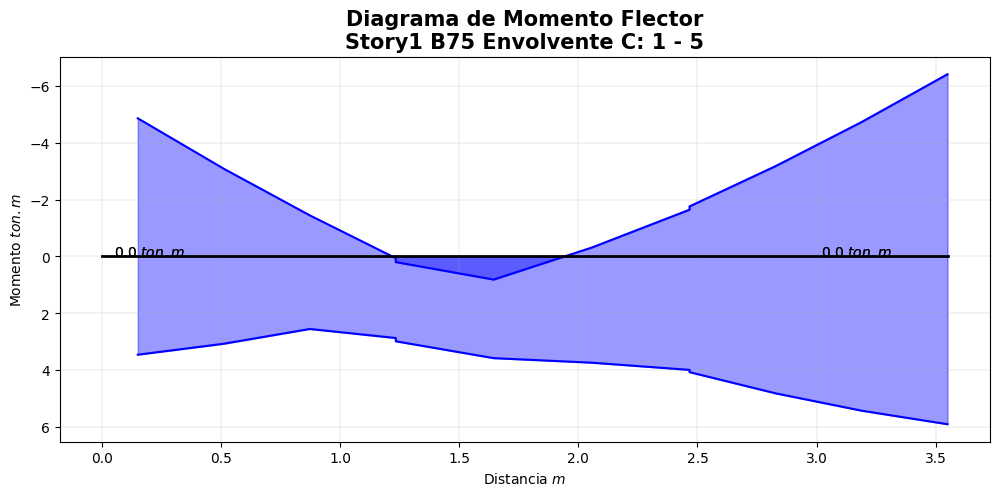

In [15]:
# CONEXION CON LA INSTANCIA DE ETABS
def connect_to_etabs():
    helper = comtypes.client.CreateObject('ETABSv1.Helper')
    helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)
    try:
        myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject")
        # print("Connected to ETABS model")
    except (OSError, comtypes.COMError):
        # print("No running instance of the program found or failed to attach.")
        sys.exit(-1)
    SapModel = myETABSObject.SapModel
    return SapModel, myETABSObject, helper


SapModel, myETABSObject, helper = connect_to_etabs()

# FILTRA LOS RESULTADOS DE LA VIGA (MOMENTO MAXIMO Y MINIMO) DEL ENVOLVENTE
start_time = time.time()
ton_m_C = 12
ret = SapModel.SetPresentUnits(ton_m_C)
table = SapModel.DatabaseTables.GetTableForDisplayArray(
    "Element Forces - Beams", GroupName="")
cols = table[2]
noOfRows = table[3]
vals = np.array_split(table[4], noOfRows)
df = pd.DataFrame(vals)
df.columns = cols

piso = ["Story1"]
nombre_viga = ["B75"]
combinacion = ["Envolvente C: 1 - 5"]
max = ["Max"]
min = ["Min"]
df = df[df.Story.isin(piso)]
df = df[df.Beam.isin(nombre_viga)]
df = df[df.OutputCase.isin(combinacion)]

df["M3"] = df["M3"].astype(float)
df["Station"] = df["Station"].astype(float)

df1 = df[df.StepType.isin(max)]
df2 = df[df.StepType.isin(min)]

df1 = df1.sort_values(by=['Station'])
end_time = time.time()
elapsed_time = end_time - start_time

# print("Tiempo de ejecución: ", round(elapsed_time, 2), "segundos")


# CONEXION DE PUNTOS EXTREMOS

Mis = float(df1.iloc[0, 14])
Mii = float(df2.iloc[0, 14])
Mds = float(df1.iloc[-1, 14])
Mdi = float(df2.iloc[-1, 14])
L = df2["Station"].max()


# PLOTEO DE LA ENVOLVENTE DE MOMENTO FLECTOR
plt.figure(figsize=(12, 5))
plt.plot(df1["Station"].values, df1["M3"].values, "b")        # plotear maximo
plt.plot(df2["Station"].values, df2["M3"].values, "b")        # plotear minimo

# plotear eje de la viga
plt.plot([0, L], [0, 0], "k", lw=2)
plt.plot([0, 0], [Mis, Mii], "b")
plt.plot([L, L], [Mds, Mdi], "b")
plt.title("Diagrama de Momento Flector"+"\n" +
          piso[0]+" "+nombre_viga[0]+" "+combinacion[0], fontsize=15, fontweight="bold")
plt.xlabel("Distancia $m$")
plt.ylabel("Momento $ton.m$")

# anotaciones
plt.annotate(str(round(Mis, 2))+" $ton.m$",
             xy=(0, Mis), xytext=(0.05, 1.05*Mis))
plt.annotate(str(round(Mds, 2))+" $ton.m$", xy=(L, Mds), xytext=(0.85*L, Mds))
plt.annotate(str(round(Mii, 2))+" $ton.m$",
             xy=(0, Mii), xytext=(0.05, 1.05*Mii))
plt.annotate(str(round(Mdi, 2))+" $ton.m$",
             xy=(L, Mdi), xytext=(0.85*L, 1.05*Mdi))
plt.gca().invert_yaxis()
plt.grid(linestyle='-', linewidth=0.2)

# achurar area de la grafica
plt.fill_between(df1["Station"].values, df1["M3"].values,
                 0, color="blue", alpha=0.4)
plt.fill_between(df2["Station"].values, df2["M3"].values,
                 0, color="blue", alpha=0.4)
plt.savefig("M3.svg", dpi=1080, bbox_inches='tight')
plt.show()

## **DISEÑO POR FLEXION**


FUNCION QUE ESCOJE LAS VARILLAS DE ACERO RECOMENDADAS EN VIGAS POR EL LIBRO DE BLANCO

<!-- ![WhatsApp Image 2024-07-09 at 16.28.52_79e04982.jpg](<attachment:WhatsApp Image 2024-07-09 at 16.28.52_79e04982.jpg>) 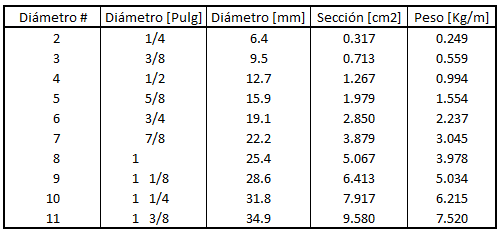 -->

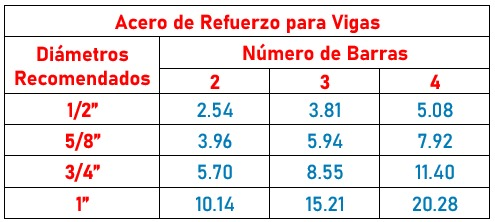

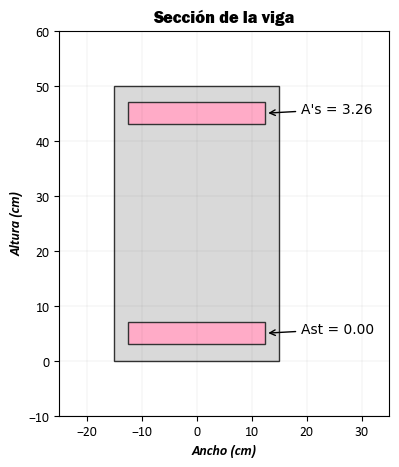

In [16]:
# problema:
# escojer el mayor valor de los momentos extremos
momentos = np.array([Mis, Mii, Mds, Mdi])
Mu = abs(np.max(momentos))

b = 30
h = 50
r = 5
fc = 210
fy = 4200

# for mu in Mu:
viga = vt.VigaR(Mu, b, h, r, fc, fy)
viga.plot(K=5)

In [17]:
# for mu in Mu:
Asc, Ast = viga.As().values()
print("-"*20)
print(f'A\'s = {Asc:.2f}')
print(f'Ast = {Ast:.2f}')

--------------------
A's = 3.26
Ast = 0.00


### **_AREAS DE ACERO A NUMERO BARRAS_**


In [18]:
# Datos de la tabla completa
data = {
    'Diámetro #': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Diámetro [Pulg]': ['1/4', '3/8', '1/2', '5/8', '3/4', '7/8', '1', '1 1/8', '1 1/4', '1 3/8'],
    'Diámetro [mm]': [6.4, 9.5, 12.7, 15.9, 19.1, 22.2, 25.4, 28.6, 31.8, 34.9],
    'Sección [cm2]': [0.317, 0.713, 1.267, 1.979, 2.850, 3.879, 5.067, 6.413, 7.917, 9.580],
    'Peso [Kg/m]': [0.249, 0.559, 0.994, 1.554, 2.237, 3.045, 3.978, 5.034, 6.255, 7.520]
}

# Crear el DataFrame completo
df_completo = pd.DataFrame(data)

# Reducir el DataFrame a las varillas recomendadas por el libro de Blanco para vigas
varillas_recomendadas = ['1/2', '5/8', '3/4', '7/8', '1']
df_vigas = df_completo[df_completo['Diámetro [Pulg]'].isin(
    varillas_recomendadas)].reset_index(drop=True)
df_vigas

,Diámetro #,Diámetro [Pulg],Diámetro [mm],Sección [cm2],Peso [Kg/m]
0,4,1/2,12.7,1.267,0.994
1,5,5/8,15.9,1.979,1.554
2,6,3/4,19.1,2.850,2.237
3,7,7/8,22.2,3.879,3.045
4,8,1,25.4,5.067,3.978


In [19]:
# for mu in Mu:
as_requerido = [Ast, Asc]  # Área de acero requerida en cm²
rr = 6  # Recubrimiento en mm
for i, As in enumerate(as_requerido):
    opcion, condicion, error = vt.elegir_varillas(As, b, rr, df_vigas)
    num_varillas = next(iter(opcion))  # Número de varillas
    diametro_pulgadas = opcion[num_varillas]  # Diámetro en pulgadas
    diametro_mm = df_vigas[df_vigas['Diámetro [Pulg]']
                           == diametro_pulgadas]['Diámetro [mm]'].values[0]
    if i % 2 == 0:
        print("-"*20)
    print(f"Área requerida: {As:.2f} cm²")
    print(f"Opción: {opcion}")
    # print(f"Condición: {condicion}")
    # print(f"Error: {error:.2f}")
    # print(f"Número de varillas: {num_varillas}")
    # print(f"Diámetro: {diametro_pulgadas} ({diametro_mm} mm)")

c:\Users\AMILCAR\OneDrive - Universidad Nacional de San Antonio Abad del Cusco\DEVELOPER\PROGRAMA DE CALCULO DE VIGAS\milca\vigas.py:598: RuntimeWarning: divide by zero encountered in scalar divide
  error = abs((num_varillas * av - as_requerido) / as_requerido)


IndexError: index 0 is out of bounds for axis 0 with size 0

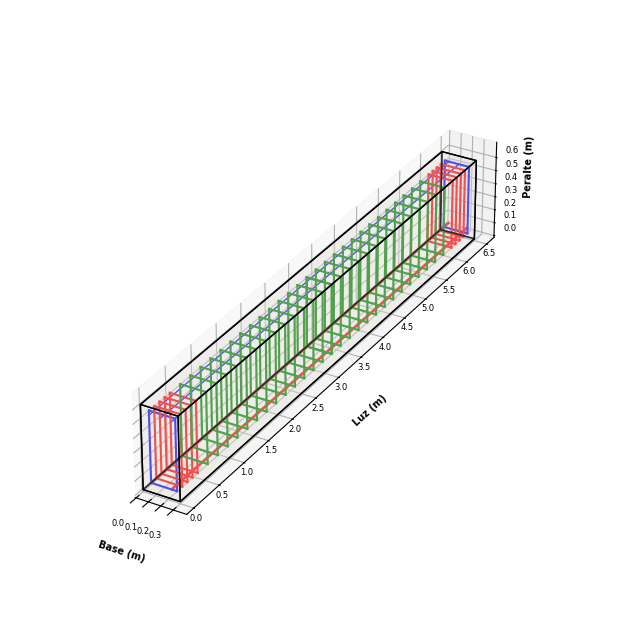

In [ ]:
# Parámetros de la geometria de la zapata
b = 0.3         # base
L = 6.5           # Luz de la viga
h = 0.6         # peralte


# varillas longitudinales (acero por flexión)
dc = 0.0127      # diámetro de las varillas en compresion
nc = 3          # numero de varillas longitudinales en compresión
dt = 0.0254     # diámetro de las varillas en tracción
nt = 2          # numero de varillas longitudinales en tracción

# estribos
de = 0.02      # diámetro de los estribos
ei = 0.05       # espaciamiento inicial
e1 = 0.05       # primer espaciamiento de los estribos (generalmente 5cm)
n1 = 1.00       # número de estribos con espaciamiento e1
e2 = 0.10       # segundo espaciamiento de los estribos
n2 = 4.00       # número de estribos con espaciamiento e2
e3 = 0.20       # tercer espaciamiento de los estribos (resto)

rr = 0.035       # recubrimiento (espesor del concreto no confinado)


vp.modelar_viga(b, L, h, rr, dc, nc, dt, nt, de, ei,
                e1, n1, e2, n2, e3, rebarExtrude=False)

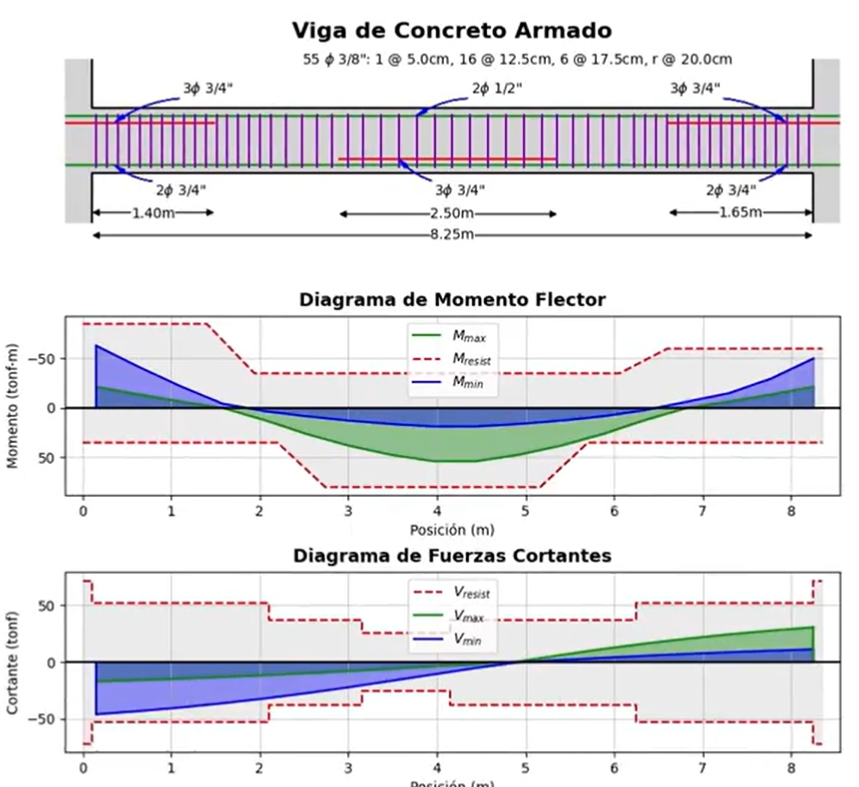


### **_VIGA CON ESTRIBOS DE N TRAMOS_**


#### **_anotaciones_**


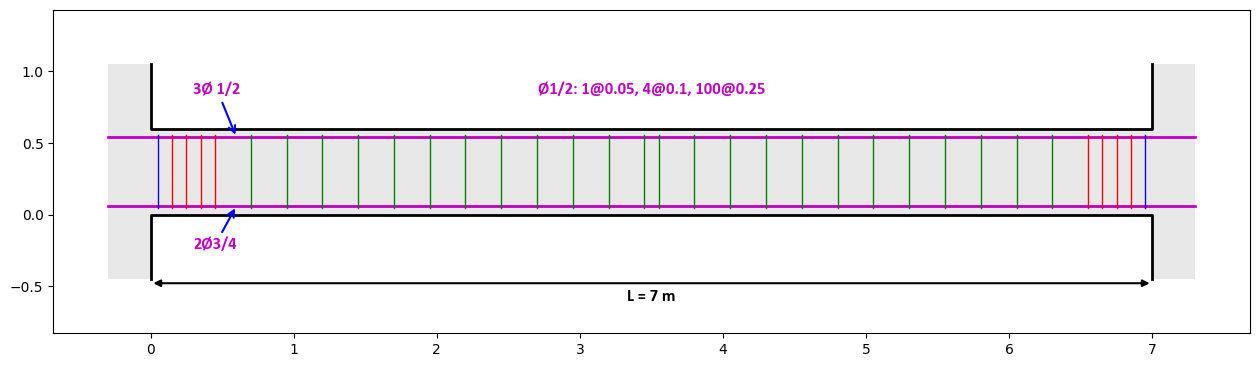

In [93]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
##############################################################################
# Parámetros de la geometría de la zapata
b = 0.3         # base
L = 7           # Luz de la viga
h = 0.6         # peralte

# Varillas longitudinales (acero por flexión)
dc = 0.0127     # diámetro de las varillas en compresión
nc = 3          # número de varillas longitudinales en compresión
dt = 0.0254     # diámetro de las varillas en tracción
nt = 2          # número de varillas longitudinales en tracción

# Estribos
de = 0.0127     # diámetro de los estribos
tramos = [
    (0.05, 1),  # (espaciamiento, número de estribos)
    (0.10, 4),
    (0.25, 100)
]

de_fracc = '1/2'
# Anotaciones de las barras longitudinales
dcp = "1/2"
dtp = "3/4"

rr = 0.035      # recubrimiento (espesor del concreto no confinado)
###############################################################################


def estribos(L, h, rr, de, tramos):
    estribos_puntos = []
    # Lista de colores para los tramos
    colores = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    recubrimiento_lateral = de + rr

    x_actual = tramos[0][0]  # Empezar desde el espaciamiento del primer tramo

    for idx, tramo in enumerate(tramos):
        espaciamiento, numero = tramo
        for i in range(1, int(numero)+1):
            x1 = x_actual + i * espaciamiento - tramos[0][0]
            x2 = L - x1
            if x1 > x2:
                break
            p1 = (x1, recubrimiento_lateral)
            p2 = (x1, h - recubrimiento_lateral)
            estribos_puntos.append([p1, p2, colores[idx]])
            p1 = (x2, recubrimiento_lateral)
            p2 = (x2, h - recubrimiento_lateral)
            estribos_puntos.append([p1, p2, colores[idx]])
        x_actual += numero * espaciamiento

    return estribos_puntos


r = dt / 2 + de + rr

# Puntos de la geometría
V = 0.75
H = 0.50
pc1 = (-H * h, -V * h)
pc2 = (0, -V * h)
pc3 = (0, 0)
pc4 = (L, 0)
pc5 = (L, -V * h)
pc6 = (L + H * h, -V * h)
pc7 = (L + H * h, (1 + V) * h)
pc8 = (L, (1 + V) * h)
pc9 = (L, h)
pc10 = (0, h)
pc11 = (0, (1 + V) * h)
pc12 = (-H * h, (1 + V) * h)
region = [pc1, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11, pc12]
borde_s = [pc8, pc9, pc10, pc11]
borde_i = [pc2, pc3, pc4, pc5]

# Aceros longitudinales
aceroSup = [(-H * h, h - r), (L + H * h, h - r)]
aceroInf = [(-H * h, r), (L + H * h, r)]

# estribos
estribos_puntos = estribos(L, h, rr, de, tramos)

# región
x, y = zip(*region)
plt.figure(figsize=((2 * H * h + L + 0.2 * h) * 2, (2 * V * h + h + h) * 2))
# 'b' es el color azul, y alpha es la transparencia
plt.fill(x, y, '#d3d3d3', edgecolor='none', alpha=0.5)

# borde
x, y = zip(*borde_s)
plt.plot(x, y, 'k', lw=2)
x, y = zip(*borde_i)
plt.plot(x, y, 'k', lw=2)
# Asegurar que los ejes X e Y tengan la misma escala
plt.axis('equal')

# aceros longitudinales
x, y = zip(*aceroSup)
plt.plot(x, y, 'm', lw=2)
x, y = zip(*aceroInf)
plt.plot(x, y, 'm', lw=2)

# estribos
for p1, p2, color in estribos_puntos:
    x, y = zip(*[p1, p2])
    plt.plot(x, y, color, lw=1)


plt.annotate(f'{nc}Ø {dcp}', xy=(1*h, h-r), xytext=(aceroSup[0][0] + 1*h, aceroSup[0][1] + 0.5*h),
             arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
             fontsize=12, fontweight='bold', color='m', fontname='Calibri')

plt.annotate(f'{nt}Ø{dtp}', xy=(1*h, r), xytext=(aceroInf[0][0] + 1*h, aceroInf[0][1] - 0.5*h),
             arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
             fontsize=12, fontweight='bold', color='m', fontname='Calibri')

# Anotación de distribución de estribos
tramos_info = ', '.join([f'{t[1]}@{t[0]}' for t in tramos])
plt.text(L/2, aceroSup[0][1] + 0.5*h, f'Ø{de_fracc}: {tramos_info}',
         fontsize=12, fontweight='bold', ha='center', color='m', fontname='Calibri')


# Anotación tipo AutoCAD para la longitud L
plt.annotate('', xy=(L, -0.80*h), xytext=(0, -0.8*h),
             arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
plt.text(L/2, -h, f'L = {L} m', fontsize=12, fontweight='bold',
         ha='center', color='black', fontname='Calibri')

# # Anotación tipo AutoCAD para el peralte h
# plt.annotate('', xy=(-0.05, h), xytext=(-0.05, 0),
#              arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
# plt.text(-0.1, h/2, f'h = {h} m', fontsize=12, fontweight='bold', va='center', color='black', fontname='Calibri', rotation=90)

# Mostrar el gráfico
plt.show()